In [9]:

index=12

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="5"

from importlib.machinery import SourceFileLoader
import uproot as up
import numpy as np
import time
import iminuit
from iminuit import Minuit
from iminuit.cost import ExtendedUnbinnedNLL

import matplotlib.pyplot as plt
import sys
import tensorflow as tf
from tensorflow.python.ops.resource_variable_ops import ResourceVariable
tf.get_logger().setLevel('INFO')

time1 = time.time()

sys.path.append('/software/pc24403/tfpcbpggsz/func')
sys.path.append('/software/pc24403/tfpcbpggsz/amp_ampgen')
sys.path.append('/software/pc24403/tfpcbpggsz/core')
from amp import *
from core_test import *
from tfmassshape import *


mc_path = '/shared/scratch/pc24403/amp_ampgen'

In [10]:


def get_mass(p1,p2):
    return ((p1[:,0]+p2[:,0])**2 - (p1[:,1]+p2[:,1])**2 - (p1[:,2]+p2[:,2])**2 - (p1[:,3]+p2[:,3])**2)


def get_p4(decay="b2dpi", cut='', index=index):

    file_name = ''
    branch_names = []
    if cut == 'int':
        file_name = f'/software/pc24403/PCBPGGSZ/Int/weighted_{decay}.root:DalitzEventList'
        branch_names = ["_1_K0S0_E", "_1_K0S0_Px", "_1_K0S0_Py", "_1_K0S0_Pz",
                         "_2_pi#_E", "_2_pi#_Px", "_2_pi#_Py", "_2_pi#_Pz",
                         "_3_pi~_E", "_3_pi~_Px", "_3_pi~_Py", "_3_pi~_Pz"]
    
    elif decay.split('_')[0] == 'b2dk' or decay.split('_')[0] == 'b2dpi':
        branch_names = ["_1_K0S0_E", "_1_K0S0_Px", "_1_K0S0_Py", "_1_K0S0_Pz",
                         "_2_pi#_E", "_2_pi#_Px", "_2_pi#_Py", "_2_pi#_Pz",
                         "_3_pi~_E", "_3_pi~_Px", "_3_pi~_Py", "_3_pi~_Pz"]
        if cut == 'p':
            file_name = f'/software/pc24403/PCBPGGSZ/outputs/toy/mass_fit/add_sw/new_frac_sw_pg/{decay}_{index}_CPrange.root:DalitzEventList'
#            file_name = f'/software/pc24403/PCBPGGSZ/outputs/toy/swap/{decay}_{comp}_{index}.root:Bplus_DalitzEventList'

        else:
            file_name = f'/software/pc24403/PCBPGGSZ/outputs/toy/mass_fit/add_sw/new_frac_sw_pg/{decay}_{index}_CPrange.root:DalitzEventList'
#            file_name = f'/software/pc24403/PCBPGGSZ/outputs/toy/swap/{decay}_{comp}_{index}.root:Bminus_DalitzEventList'

    tree = up.open(file_name)
  # Load the branches as arrays
    charge = '(Bac_ID>0)'
    if cut == 'm':
        charge = '(Bac_ID<0)'
       
    array = tree.arrays(branch_names, charge)
    _p1 = np.asarray([array["_1_K0S0_E"], array["_1_K0S0_Px"], array["_1_K0S0_Py"], array["_1_K0S0_Pz"]])
    _p2 = np.asarray([array["_2_pi#_E"], array["_2_pi#_Px"], array["_2_pi#_Py"], array["_2_pi#_Pz"]])
    _p3 = np.asarray([array["_3_pi~_E"], array["_3_pi~_Px"], array["_3_pi~_Py"], array["_3_pi~_Pz"]])
    
    # convert 4*1000 into a vectot<double>
    p1 = np.transpose(_p1)
    p2 = np.transpose(_p2)
    p3 = np.transpose(_p3)

    p1bar = np.hstack((p1[:, :1], np.negative(p1[:, 1:])))
    p2bar = np.hstack((p2[:, :1], np.negative(p2[:, 1:])))
    p3bar = np.hstack((p3[:, :1], np.negative(p3[:, 1:])))



    return p1, p2, p3, p1bar, p2bar, p3bar

def load_int_amp(args):
    p1, p2, p3 = args

    return Kspipi.AMP(p1.tolist(), p2.tolist(), p3.tolist())

def getAmp(decay='b2dpi', cut='int', index=index):

    start_time = time.time()
    p1, p2, p3, p1bar, p2bar, p3bar = get_p4(decay=decay, cut=cut, index=index)
    amplitude = []
    amplitudeBar = []

    p1_np = np.array(p1)
    p2_np = np.array(p2)
    p3_np = np.array(p3)
    p1bar_np = np.array(p1bar)
    p2bar_np = np.array(p2bar)
    p3bar_np = np.array(p3bar)

    data = [(p1_np[i], p2_np[i], p3_np[i]) for i in range(len(p1_np))]
    with Pool(processes=multiprocessing.cpu_count()) as pool:
        amplitude.append(pool.map(load_int_amp, data))
    data_bar = [(p1bar_np[i], p3bar_np[i], p2bar_np[i]) for i in range(len(p1bar_np))]
    with Pool(processes=multiprocessing.cpu_count()) as pool:
        amplitudeBar.append(pool.map(load_int_amp, data_bar))
    
    end_time = time.time()
    print(f'Amplitude for {decay} loaded in {end_time-start_time} seconds')
    amplitude = np.array(amplitude)
    amplitudeBar = np.array(amplitudeBar)

    return amplitude, amplitudeBar
    
def get_p4_v2(decay="b2dpi", cut='', index=index, comp='sig'):

    file_name = ''
    branch_names = []
    if cut == 'int':
        file_name = f'/software/pc24403/PCBPGGSZ/Int/weighted_{decay}.root:DalitzEventList'
        branch_names = ["_1_K0S0_E", "_1_K0S0_Px", "_1_K0S0_Py", "_1_K0S0_Pz",
                         "_2_pi#_E", "_2_pi#_Px", "_2_pi#_Py", "_2_pi#_Pz",
                         "_3_pi~_E", "_3_pi~_Px", "_3_pi~_Py", "_3_pi~_Pz"]
    
    elif decay.split('_')[0] == 'b2dk' or decay.split('_')[0] == 'b2dpi':
        branch_names = ["_1_K0S0_E", "_1_K0S0_Px", "_1_K0S0_Py", "_1_K0S0_Pz",
                         "_2_pi#_E", "_2_pi#_Px", "_2_pi#_Py", "_2_pi#_Pz",
                         "_3_pi~_E", "_3_pi~_Px", "_3_pi~_Py", "_3_pi~_Pz", "B_M"]
        if cut == 'p':
            file_name = f'/software/pc24403/PCBPGGSZ/outputs/toy/mass_fit/add_sw/new_frac_sw_pg/{decay}_{index}_CPrange.root:DalitzEventList'
#            file_name = f'/software/pc24403/PCBPGGSZ/outputs/toy/swap/{decay}_{comp}_{index}.root:Bplus_DalitzEventList'

        else:
            file_name = f'/software/pc24403/PCBPGGSZ/outputs/toy/mass_fit/add_sw/new_frac_sw_pg/{decay}_{index}_CPrange.root:DalitzEventList'
#            file_name = f'/software/pc24403/PCBPGGSZ/outputs/toy/swap/{decay}_{comp}_{index}.root:Bminus_DalitzEventList'

    tree = up.open(file_name)
  # Load the branches as arrays
    charge = '(Bac_ID>0)'
    if cut == 'm':
        charge = '(Bac_ID<0)'
    
    array = tree.arrays(branch_names, charge)
       

    _p1 = np.asarray([array["_1_K0S0_E"], array["_1_K0S0_Px"], array["_1_K0S0_Py"], array["_1_K0S0_Pz"]])
    _p2 = np.asarray([array["_2_pi#_E"], array["_2_pi#_Px"], array["_2_pi#_Py"], array["_2_pi#_Pz"]])
    _p3 = np.asarray([array["_3_pi~_E"], array["_3_pi~_Px"], array["_3_pi~_Py"], array["_3_pi~_Pz"]])
    
    # convert 4*1000 into a vectot<double>
    p1 = np.transpose(_p1)
    p2 = np.transpose(_p2)
    p3 = np.transpose(_p3)

    p1bar = np.hstack((p1[:, :1], np.negative(p1[:, 1:])))
    p2bar = np.hstack((p2[:, :1], np.negative(p2[:, 1:])))
    p3bar = np.hstack((p3[:, :1], np.negative(p3[:, 1:])))

    B_M = np.zeros(len(p1))
    if cut != 'int':
        
        B_M = np.asarray([array["B_M"]])


    return p1, p2, p3, p1bar, p2bar, p3bar, B_M


def getMass(decay='b2dpi', cut='int', index=index):

    start_time = time.time()
    p1, p2, p3, p1bar, p2bar, p3bar = get_p4(decay=decay, cut=cut, index=index)
    amplitude = []
    amplitudeBar = []

    p1_np = np.array(p1)
    p2_np = np.array(p2)
    p3_np = np.array(p3)
    p1bar_np = np.array(p1bar)
    p2bar_np = np.array(p2bar)
    p3bar_np = np.array(p3bar)

    s12 = get_mass(p1_np, p2_np)
    s13 = get_mass(p1_np, p3_np)

    return s12, s13

def getMass_v2(decay='b2dpi', cut='int', comp='sig', index=index):

    start_time = time.time()
    p1, p2, p3, p1bar, p2bar, p3bar, B_M = get_p4_v2(decay=decay, cut=cut, comp=comp, index=index)
    amplitude = []
    amplitudeBar = []

    p1_np = np.array(p1)
    p2_np = np.array(p2)
    p3_np = np.array(p3)
    p1bar_np = np.array(p1bar)
    p2bar_np = np.array(p2bar)
    p3bar_np = np.array(p3bar)

    s12 = get_mass(p1_np, p2_np)
    s13 = get_mass(p1_np, p3_np)

    return s12, s13, B_M




In [11]:


#config_mass_shape_output = SourceFileLoader('config_mass_shape_output', '/software/pc24403/PCBPGGSZ/outputs/toy/mass_fit/config/%s'%(f'config_CPrange_input_{index}.py')).load_module()
config_mass_shape_output = SourceFileLoader('config_mass_shape_output', '/software/pc24403/PCBPGGSZ/mass_fit/config/%s'%(f'config_CPrange_input_All.py')).load_module()


varDict = config_mass_shape_output.getconfig()
print_yields = True
sig_yield = {}
Bdecays = ['b2dk', 'b2dpi']
Types = ['LL', 'DD']
for bdecay in Bdecays:
    for Type in Types:
        decay = ''

        if bdecay == 'b2dk':
            decay = 'DK_KsPiPi_%s'%Type
        elif bdecay == 'b2dpi':
            decay = 'DPi_KsPiPi_%s'%Type

        #print yields
        if print_yields == True:
            print('Yields:')
            print('Sig: %.2f'%varDict['n_sig_%s'%decay])
            print('MisID: %.2f'%varDict['n_misid_%s'%decay])
            print('Low: %.2f'%varDict['n_low_%s'%decay])
            print('Comb: %.2f'%varDict['n_comb_%s'%decay])
            if bdecay == 'b2dk':
                print('Low MisID: %.2f'%varDict['n_low_misID_%s'%decay])
                print('Low Bs2DKPi: %.2f'%varDict['n_low_Bs2DKPi_%s'%decay])
                sum_yields = varDict['n_sig_%s'%decay] + varDict['n_misid_%s'%decay] + varDict['n_low_%s'%decay] + varDict['n_comb_%s'%decay] + varDict['n_low_misID_%s'%decay] + varDict['n_low_Bs2DKPi_%s'%decay]
            else:
                sum_yields = varDict['n_sig_%s'%decay] + varDict['n_misid_%s'%decay] + varDict['n_low_%s'%decay] + varDict['n_comb_%s'%decay]
            print('Sum: %.2f'%sum_yields)



pdfs_data = {}
s12_data = {}
s13_data = {}
Bu_M = {}
mass_pdfs = {}
for decay in ['b2dk_LL', 'b2dk_DD', 'b2dpi_LL', 'b2dpi_DD']:
    for charge in ['p', 'm']:
        new_decay = decay + '_'+ charge
        print('--- INFO: Building function for %s...'%new_decay)
        s12_data[new_decay], s13_data[new_decay], Bu_M[new_decay] = getMass_v2(decay, charge, index)
        Bu_M[new_decay] = tf.cast(Bu_M[new_decay], tf.float64)
        pdfs_data[new_decay] = preparePdf_data(Bu_M[new_decay], varDict, decay)

comps = ['sig', 'misid', 'comb', 'low', 'low_misID', 'low_Bs2DKPi']
for decay in ['b2dk_LL', 'b2dk_DD', 'b2dpi_LL', 'b2dpi_DD']:
    for charge in ['p', 'm']:
        new_decay = decay + '_'+ charge
        mass_pdfs[new_decay] = {}
        for comp in comps:
            if decay.split('_')[0] == 'b2dpi' and (comp == 'low_Bs2DKPi' or comp == 'low_misID'): continue
            mass_pdfs[new_decay][comp] = pdfs_data[new_decay][comp](Bu_M[new_decay])
time2 = time.time()
        
print('INFO: mass Function loaded...')




logpath = '/dice/users/pc24403/BPGGSZ/sim_fit_new'
if os.path.exists(logpath) == False:
    os.mkdir(logpath)


print('INFO: Initialize the amplitudes...')

amp_Data_dk_dd_m = []
ampbar_Data_dk_dd_m = []
amp_Data_dk_dd_p = []
ampbar_Data_dk_dd_p = []
amp_Data_dk_ll_m = []
ampbar_Data_dk_ll_m = []
amp_Data_dk_ll_p = []
ampbar_Data_dk_ll_p = []
amp_dk_ll_p = []
amp_dk_ll_m = []
amp_dk_dd_p = []
amp_dk_dd_m = []
ampbar_dk_ll_p = []
ampbar_dk_ll_m = []
ampbar_dk_dd_p = []
ampbar_dk_dd_m = []

amp_Data_dpi_dd_m = []
ampbar_Data_dpi_dd_m = []
amp_Data_dpi_dd_p = []
ampbar_Data_dpi_dd_p = []
amp_Data_dpi_ll_m = []
ampbar_Data_dpi_ll_m = []
amp_Data_dpi_ll_p = []
ampbar_Data_dpi_ll_p = []
amp_dpi_ll_p = []
amp_dpi_ll_m = []
amp_dpi_dd_p = []
amp_dpi_dd_m = []
ampbar_dpi_ll_p = []
ampbar_dpi_ll_m = []
ampbar_dpi_dd_p = []
ampbar_dpi_dd_m = []


print('INFO: Loading amplitudes...')

amp_Data_dk_dd_p, ampbar_Data_dk_dd_p = getAmp('b2dk_DD', 'p', index=index)
amp_Data_dk_dd_m, ampbar_Data_dk_dd_m = getAmp('b2dk_DD', 'm', index=index)
amp_Data_dk_ll_p, ampbar_Data_dk_ll_p = getAmp('b2dk_LL', 'p', index=index)
amp_Data_dk_ll_m, ampbar_Data_dk_ll_m = getAmp('b2dk_LL', 'm', index=index)
amp_dk_dd_p = np.load(mc_path + '/Int_b2dk_DD_p_amp.npy')
ampbar_dk_dd_p = np.load(mc_path + '/Int_b2dk_DD_p_ampbar.npy')
amp_dk_dd_m = np.load(mc_path + '/Int_b2dk_DD_m_amp.npy')
ampbar_dk_dd_m = np.load(mc_path + '/Int_b2dk_DD_m_ampbar.npy')
amp_dk_ll_p = np.load(mc_path + '/Int_b2dk_LL_p_amp.npy')
ampbar_dk_ll_p = np.load(mc_path + '/Int_b2dk_LL_p_ampbar.npy')
amp_dk_ll_m = np.load(mc_path + '/Int_b2dk_LL_m_amp.npy')
ampbar_dk_ll_m = np.load(mc_path + '/Int_b2dk_LL_m_ampbar.npy')

amp_Data_dpi_dd_p, ampbar_Data_dpi_dd_p = getAmp('b2dpi_DD', 'p', index=index)
amp_Data_dpi_dd_m, ampbar_Data_dpi_dd_m = getAmp('b2dpi_DD', 'm', index=index)
amp_Data_dpi_ll_p, ampbar_Data_dpi_ll_p = getAmp('b2dpi_LL', 'p', index=index)
amp_Data_dpi_ll_m, ampbar_Data_dpi_ll_m = getAmp('b2dpi_LL', 'm', index=index)
amp_dpi_dd_p = np.load(mc_path + '/Int_b2dpi_DD_p_amp.npy')
ampbar_dpi_dd_p = np.load(mc_path + '/Int_b2dpi_DD_p_ampbar.npy')
amp_dpi_dd_m = np.load(mc_path + '/Int_b2dpi_DD_m_amp.npy')
ampbar_dpi_dd_m = np.load(mc_path + '/Int_b2dpi_DD_m_ampbar.npy')
amp_dpi_ll_p = np.load(mc_path + '/Int_b2dpi_LL_p_amp.npy')
ampbar_dpi_ll_p = np.load(mc_path + '/Int_b2dpi_LL_p_ampbar.npy')
amp_dpi_ll_m = np.load(mc_path + '/Int_b2dpi_LL_m_amp.npy')
ampbar_dpi_ll_m = np.load(mc_path + '/Int_b2dpi_LL_m_ampbar.npy')

#Post to TF constant
amp_Data_dk_dd_p = tf.constant(amp_Data_dk_dd_p, dtype=tf.complex128)
ampbar_Data_dk_dd_p = tf.constant(ampbar_Data_dk_dd_p, dtype=tf.complex128)
amp_Data_dk_dd_m = tf.constant(amp_Data_dk_dd_m, dtype=tf.complex128)
ampbar_Data_dk_dd_m = tf.constant(ampbar_Data_dk_dd_m, dtype=tf.complex128)
amp_Data_dk_ll_p = tf.constant(amp_Data_dk_ll_p, dtype=tf.complex128)
ampbar_Data_dk_ll_p = tf.constant(ampbar_Data_dk_ll_p, dtype=tf.complex128)
amp_Data_dk_ll_m = tf.constant(amp_Data_dk_ll_m, dtype=tf.complex128)
ampbar_Data_dk_ll_m = tf.constant(ampbar_Data_dk_ll_m, dtype=tf.complex128)
amp_dk_dd_p = tf.constant(amp_dk_dd_p, dtype=tf.complex128)
ampbar_dk_dd_p = tf.constant(ampbar_dk_dd_p, dtype=tf.complex128)
amp_dk_dd_m = tf.constant(amp_dk_dd_m, dtype=tf.complex128)
ampbar_dk_dd_m = tf.constant(ampbar_dk_dd_m, dtype=tf.complex128)
amp_dk_ll_p = tf.constant(amp_dk_ll_p, dtype=tf.complex128)
ampbar_dk_ll_p = tf.constant(ampbar_dk_ll_p, dtype=tf.complex128)
amp_dk_ll_m = tf.constant(amp_dk_ll_m, dtype=tf.complex128)
ampbar_dk_ll_m = tf.constant(ampbar_dk_ll_m, dtype=tf.complex128)
amp_dpi_dd_p = tf.constant(amp_dpi_dd_p, dtype=tf.complex128)
ampbar_dpi_dd_p = tf.constant(ampbar_dpi_dd_p, dtype=tf.complex128)
amp_dpi_dd_m = tf.constant(amp_dpi_dd_m, dtype=tf.complex128)
ampbar_dpi_dd_m = tf.constant(ampbar_dpi_dd_m, dtype=tf.complex128)
amp_dpi_ll_p = tf.constant(amp_dpi_ll_p, dtype=tf.complex128)
ampbar_dpi_ll_p = tf.constant(ampbar_dpi_ll_p, dtype=tf.complex128)
amp_dpi_ll_m = tf.constant(amp_dpi_ll_m, dtype=tf.complex128)
ampbar_dpi_ll_m = tf.constant(ampbar_dpi_ll_m, dtype=tf.complex128)

time3 = time.time()


@tf.function
def prod_nll_dk_dd(x):

    decay = 'b2dk_DD'
    fracDD = 0.33

    nsig = x[6]*0.5
    nmisid = x[9]/(varDict['pideff_DPi_KsPiPi_p_to_p_DD']) * varDict['pideff_DPi_KsPiPi_p_to_k_DD']*0.5
    ncomb = x[7]*0.5
    nlow = x[8]*0.5
    frac_low_misID = varDict['cp_range_n_low_misID_DK_KsPiPi_DD']/varDict['cp_range_n_low_DPi_KsPiPi_DD']
    nlow_misID = x[11]*frac_low_misID*0.5
    nlow_Bs2DKPi = varDict['cp_range_n_low_Bs2DKPi_DK_KsPiPi_DD']*0.5



    normalisationCrossTerms_p = totalAmplitudeSquared_Integrated_crossTerm(amp_dk_dd_p, ampbar_dk_dd_p)
    normalisationCrossTerms_m = totalAmplitudeSquared_Integrated_crossTerm(amp_dk_dd_m, ampbar_dk_dd_m)
    misid_normalisationCrossTerms_p = totalAmplitudeSquared_Integrated_crossTerm(amp_dpi_dd_p, ampbar_dpi_dd_p)
    misid_normalisationCrossTerms_m = totalAmplitudeSquared_Integrated_crossTerm(amp_dpi_dd_m, ampbar_dpi_dd_m)

    normA_p = tf.math.reduce_mean(tf.math.abs(amp_dk_dd_p)**2)
    normAbar_p = tf.math.reduce_mean(tf.math.abs(ampbar_dk_dd_p)**2)
    normA_m = tf.math.reduce_mean(tf.math.abs(amp_dk_dd_m)**2)
    normAbar_m = tf.math.reduce_mean(tf.math.abs(ampbar_dk_dd_m)**2)

    misid_normA_p = tf.math.reduce_mean(tf.math.abs(amp_dpi_dd_p)**2)
    misid_normAbar_p = tf.math.reduce_mean(tf.math.abs(ampbar_dpi_dd_p)**2)
    misid_normA_m = tf.math.reduce_mean(tf.math.abs(amp_dpi_dd_m)**2)
    misid_normAbar_m = tf.math.reduce_mean(tf.math.abs(ampbar_dpi_dd_m)**2)

    sig_prob_p = nsig * mass_pdfs[decay+'_p']['sig'] * prod_totalAmplitudeSquared_XY(1, amp_Data_dk_dd_p, ampbar_Data_dk_dd_p, x, mass_pdfs[decay+'_p']['sig'], mass_pdfs[decay+'_m']['sig'], Bu_M[decay+'_p'], Bu_M[decay+'_m'])
    sig_prob_m = nsig * mass_pdfs[decay+'_m']['sig'] * prod_totalAmplitudeSquared_XY(-1, amp_Data_dk_dd_m, ampbar_Data_dk_dd_m, x, mass_pdfs[decay+'_p']['sig'], mass_pdfs[decay+'_m']['sig'], Bu_M[decay+'_p'], Bu_M[decay+'_m'])
    misid_prob_p = nmisid * mass_pdfs[decay+'_p']['misid'] * prod_totalAmplitudeSquared_DPi_XY(1, amp_Data_dk_dd_p, ampbar_Data_dk_dd_p, x, mass_pdfs[decay+'_p']['misid'], mass_pdfs[decay+'_m']['misid'], Bu_M[decay+'_p'], Bu_M[decay+'_m'])
    misid_prob_m = nmisid * mass_pdfs[decay+'_m']['misid'] * prod_totalAmplitudeSquared_DPi_XY(-1, amp_Data_dk_dd_m, ampbar_Data_dk_dd_m, x, mass_pdfs[decay+'_p']['misid'], mass_pdfs[decay+'_m']['misid'], Bu_M[decay+'_p'], Bu_M[decay+'_m'])
    comb_prob_p = ncomb * mass_pdfs[decay+'_p']['comb'] * prod_comb(amp_Data_dk_dd_p, ampbar_Data_dk_dd_p, x, mass_pdfs[decay+'_p'], Bu_M[decay+'_p'], fracDD=fracDD)
    comb_prob_m = ncomb * mass_pdfs[decay+'_m']['comb'] * prod_comb(amp_Data_dk_dd_m, ampbar_Data_dk_dd_m, x, mass_pdfs[decay+'_m'], Bu_M[decay+'_m'], fracDD=fracDD)
    low_prob_p = nlow * mass_pdfs[decay+'_p']['low'] * prod_low(1, amp_Data_dk_dd_p, ampbar_Data_dk_dd_p, x, mass_pdfs[decay+'_p'], Bu_M[decay+'_p'], type='low')
    low_prob_m = nlow * mass_pdfs[decay+'_m']['low'] * prod_low(-1, amp_Data_dk_dd_m, ampbar_Data_dk_dd_m, x, mass_pdfs[decay+'_m'], Bu_M[decay+'_m'], type='low')
    low_misID_prob_p =  nlow_misID * mass_pdfs[decay+'_p']['low_misID'] * prod_low(1, amp_Data_dk_dd_p, ampbar_Data_dk_dd_p, x, mass_pdfs[decay+'_p'], Bu_M[decay+'_p'], type='low_misID')
    low_misID_prob_m =  nlow_misID * mass_pdfs[decay+'_m']['low_misID'] * prod_low(-1, amp_Data_dk_dd_m, ampbar_Data_dk_dd_m, x, mass_pdfs[decay+'_m'], Bu_M[decay+'_m'], type='low_misID')
    low_Bs2DKPi_prob_p = nlow_Bs2DKPi * mass_pdfs[decay+'_p']['low_Bs2DKPi'] * prod_low(1, amp_Data_dk_dd_p, ampbar_Data_dk_dd_p, x, mass_pdfs[decay+'_p'], Bu_M[decay+'_p'], type='low_Bs2DKPi')
    low_Bs2DKPi_prob_m = nlow_Bs2DKPi * mass_pdfs[decay+'_m']['low_Bs2DKPi'] * prod_low(-1, amp_Data_dk_dd_m, ampbar_Data_dk_dd_m, x, mass_pdfs[decay+'_m'], Bu_M[decay+'_m'], type='low_Bs2DKPi')



    total_yield = (nsig + nmisid + ncomb + nlow + nlow_misID + nlow_Bs2DKPi)*2
    
    normalisation_Bplus = totalAmplitudeSquared_Integrated(1, normA_p, normAbar_p, normalisationCrossTerms_p, x)
    normalisation_Bminus = totalAmplitudeSquared_Integrated(-1, normA_m, normAbar_m, normalisationCrossTerms_m, x)
    misid_normalisation_Bplus = totalAmplitudeSquared_DPi_Integrated(1, misid_normA_p, misid_normAbar_p, misid_normalisationCrossTerms_p, x)
    misid_normalisation_Bminus = totalAmplitudeSquared_DPi_Integrated(-1, misid_normA_m, misid_normAbar_m, misid_normalisationCrossTerms_m, x) 

    comb_normalisation_Bplus = tf.cast((normA_p + normAbar_p)*0.5*fracDD + (1-fracDD), tf.float64)
    comb_normalisation_Bminus = tf.cast((normA_m + normAbar_m)*0.5*fracDD + (1-fracDD), tf.float64)
    low_normalisation_Bplus = tf.cast(normAbar_p, tf.float64)
    low_normalisation_Bminus = tf.cast(normA_m, tf.float64)
    low_Bs2DKPi_normalisation_Bplus = tf.cast(normA_p, tf.float64)
    low_Bs2DKPi_normalisation_Bminus = tf.cast(normAbar_m, tf.float64)

    ll_data_p = clip_log((sig_prob_p/normalisation_Bplus) + (misid_prob_p/misid_normalisation_Bplus) + (comb_prob_p/comb_normalisation_Bplus) + (low_prob_p/low_normalisation_Bplus) + (low_misID_prob_p/low_normalisation_Bplus) + (low_Bs2DKPi_prob_p/low_Bs2DKPi_normalisation_Bplus))
    ll_data_m = clip_log((sig_prob_m/normalisation_Bminus) + (misid_prob_m/misid_normalisation_Bminus) + (comb_prob_m/comb_normalisation_Bminus) + (low_prob_m/low_normalisation_Bminus) + (low_misID_prob_m/low_normalisation_Bminus) + (low_Bs2DKPi_prob_m/low_Bs2DKPi_normalisation_Bminus))


    ext_nll = (tf.reduce_sum( -2* ll_data_p) + tf.reduce_sum( -2*ll_data_m) + 2 * total_yield)
    nll = tf.reduce_sum( -2* ll_data_p) + tf.reduce_sum( -2*ll_data_m)  
    return ext_nll

@tf.function
def prod_nll_dk_ll(x):

    decay = 'b2dk_LL'
    fracDD = 0.30


    nsig = x[6]*0.5
    nmisid = x[9]/(varDict['pideff_DPi_KsPiPi_p_to_p_LL']) * varDict['pideff_DPi_KsPiPi_p_to_k_LL']*0.5
    ncomb = x[7]*0.5
    nlow = x[8]*0.5
    frac_low_misID = varDict['cp_range_n_low_misID_DK_KsPiPi_LL']/varDict['cp_range_n_low_DPi_KsPiPi_LL']
    nlow_misID = x[11]*frac_low_misID*0.5
    nlow_Bs2DKPi = varDict['cp_range_n_low_Bs2DKPi_DK_KsPiPi_LL']*0.5

    normalisationCrossTerms_p = totalAmplitudeSquared_Integrated_crossTerm(amp_dk_ll_p, ampbar_dk_ll_p)
    normalisationCrossTerms_m = totalAmplitudeSquared_Integrated_crossTerm(amp_dk_ll_m, ampbar_dk_ll_m)
    misid_normalisationCrossTerms_p = totalAmplitudeSquared_Integrated_crossTerm(amp_dpi_ll_p, ampbar_dpi_ll_p)
    misid_normalisationCrossTerms_m = totalAmplitudeSquared_Integrated_crossTerm(amp_dpi_ll_m, ampbar_dpi_ll_m)
    normA_p = tf.math.reduce_mean(tf.math.abs(amp_dk_ll_p)**2)
    normAbar_p = tf.math.reduce_mean(tf.math.abs(ampbar_dk_ll_p)**2)
    normA_m = tf.math.reduce_mean(tf.math.abs(amp_dk_ll_m)**2)
    normAbar_m = tf.math.reduce_mean(tf.math.abs(ampbar_dk_ll_m)**2)

    misid_normA_p = tf.math.reduce_mean(tf.math.abs(amp_dpi_ll_p)**2)
    misid_normAbar_p = tf.math.reduce_mean(tf.math.abs(ampbar_dpi_ll_p)**2)
    misid_normA_m = tf.math.reduce_mean(tf.math.abs(amp_dpi_ll_m)**2)
    misid_normAbar_m = tf.math.reduce_mean(tf.math.abs(ampbar_dpi_ll_m)**2)

    sig_prob_p = prod_totalAmplitudeSquared_XY(1, amp_Data_dk_ll_p, ampbar_Data_dk_ll_p, x, pdfs_data[decay+'_p']['sig'], pdfs_data[decay+'_m']['sig'], Bu_M[decay+'_p'], Bu_M[decay+'_m'])
    sig_prob_m = prod_totalAmplitudeSquared_XY(-1, amp_Data_dk_ll_m, ampbar_Data_dk_ll_m, x, pdfs_data[decay+'_p']['sig'], pdfs_data[decay+'_m']['sig'], Bu_M[decay+'_p'], Bu_M[decay+'_m'])


    sig_prob_p = nsig * mass_pdfs[decay+'_p']['sig'] * prod_totalAmplitudeSquared_XY(1, amp_Data_dk_ll_p, ampbar_Data_dk_ll_p, x, mass_pdfs[decay+'_p']['sig'], mass_pdfs[decay+'_m']['sig'], Bu_M[decay+'_p'], Bu_M[decay+'_m'])
    sig_prob_m = nsig * mass_pdfs[decay+'_m']['sig'] * prod_totalAmplitudeSquared_XY(-1, amp_Data_dk_ll_m, ampbar_Data_dk_ll_m, x, mass_pdfs[decay+'_p']['sig'], mass_pdfs[decay+'_m']['sig'], Bu_M[decay+'_p'], Bu_M[decay+'_m'])
    misid_prob_p = nmisid * mass_pdfs[decay+'_p']['misid'] * prod_totalAmplitudeSquared_DPi_XY(1, amp_Data_dk_ll_p, ampbar_Data_dk_ll_p, x, mass_pdfs[decay+'_p']['misid'], mass_pdfs[decay+'_m']['misid'], Bu_M[decay+'_p'], Bu_M[decay+'_m'])
    misid_prob_m = nmisid * mass_pdfs[decay+'_m']['misid'] * prod_totalAmplitudeSquared_DPi_XY(-1, amp_Data_dk_ll_m, ampbar_Data_dk_ll_m, x, mass_pdfs[decay+'_p']['misid'], mass_pdfs[decay+'_m']['misid'], Bu_M[decay+'_p'], Bu_M[decay+'_m'])
    comb_prob_p = ncomb * mass_pdfs[decay+'_p']['comb'] * prod_comb(amp_Data_dk_ll_p, ampbar_Data_dk_ll_p, x, mass_pdfs[decay+'_p'], Bu_M[decay+'_p'], fracDD=fracDD)
    comb_prob_m = ncomb * mass_pdfs[decay+'_m']['comb'] * prod_comb(amp_Data_dk_ll_m, ampbar_Data_dk_ll_m, x, mass_pdfs[decay+'_m'], Bu_M[decay+'_m'], fracDD=fracDD)
    low_prob_p = nlow * mass_pdfs[decay+'_p']['low'] * prod_low(1, amp_Data_dk_ll_p, ampbar_Data_dk_ll_p, x, mass_pdfs[decay+'_p'], Bu_M[decay+'_p'], type='low')
    low_prob_m = nlow * mass_pdfs[decay+'_m']['low'] * prod_low(-1, amp_Data_dk_ll_m, ampbar_Data_dk_ll_m, x, mass_pdfs[decay+'_m'], Bu_M[decay+'_m'], type='low')
    low_misID_prob_p =  nlow_misID * mass_pdfs[decay+'_p']['low_misID'] * prod_low(1, amp_Data_dk_ll_p, ampbar_Data_dk_ll_p, x, mass_pdfs[decay+'_p'], Bu_M[decay+'_p'], type='low_misID')
    low_misID_prob_m =  nlow_misID * mass_pdfs[decay+'_m']['low_misID'] * prod_low(-1, amp_Data_dk_ll_m, ampbar_Data_dk_ll_m, x, mass_pdfs[decay+'_m'], Bu_M[decay+'_m'], type='low_misID')
    low_Bs2DKPi_prob_p = nlow_Bs2DKPi * mass_pdfs[decay+'_p']['low_Bs2DKPi'] * prod_low(1, amp_Data_dk_ll_p, ampbar_Data_dk_ll_p, x, mass_pdfs[decay+'_p'], Bu_M[decay+'_p'], type='low_Bs2DKPi')
    low_Bs2DKPi_prob_m = nlow_Bs2DKPi * mass_pdfs[decay+'_m']['low_Bs2DKPi'] * prod_low(-1, amp_Data_dk_ll_m, ampbar_Data_dk_ll_m, x, mass_pdfs[decay+'_m'], Bu_M[decay+'_m'], type='low_Bs2DKPi')



    total_yield = (nsig + nmisid + ncomb + nlow + nlow_misID + nlow_Bs2DKPi)*2

    
    normalisation_Bplus = totalAmplitudeSquared_Integrated(1, normA_p, normAbar_p, normalisationCrossTerms_p, x)
    normalisation_Bminus = totalAmplitudeSquared_Integrated(-1, normA_m, normAbar_m, normalisationCrossTerms_m, x)
    misid_normalisation_Bplus = totalAmplitudeSquared_DPi_Integrated(1, misid_normA_p, misid_normAbar_p, misid_normalisationCrossTerms_p, x)
    misid_normalisation_Bminus = totalAmplitudeSquared_DPi_Integrated(-1, misid_normA_m, misid_normAbar_m, misid_normalisationCrossTerms_m, x) 


    comb_normalisation_Bplus = tf.cast((normA_p + normAbar_p)*0.5*fracDD + (1-fracDD), tf.float64)
    comb_normalisation_Bminus = tf.cast((normA_m + normAbar_m)*0.5*fracDD + (1-fracDD), tf.float64)
    low_normalisation_Bplus = tf.cast(normAbar_p, tf.float64)
    low_normalisation_Bminus = tf.cast(normA_m, tf.float64)
    low_Bs2DKPi_normalisation_Bplus = tf.cast(normA_p, tf.float64)
    low_Bs2DKPi_normalisation_Bminus = tf.cast(normAbar_m, tf.float64)

    ll_data_p = clip_log((sig_prob_p/normalisation_Bplus) + (misid_prob_p/misid_normalisation_Bplus) + (comb_prob_p/comb_normalisation_Bplus) + (low_prob_p/low_normalisation_Bplus) + (low_misID_prob_p/low_normalisation_Bplus) + (low_Bs2DKPi_prob_p/low_Bs2DKPi_normalisation_Bplus))
    ll_data_m = clip_log((sig_prob_m/normalisation_Bminus) + (misid_prob_m/misid_normalisation_Bminus) + (comb_prob_m/comb_normalisation_Bminus) + (low_prob_m/low_normalisation_Bminus) + (low_misID_prob_m/low_normalisation_Bminus) + (low_Bs2DKPi_prob_m/low_Bs2DKPi_normalisation_Bminus))

    ext_nll = (tf.reduce_sum( -2* ll_data_p) + tf.reduce_sum( -2*ll_data_m) + 2 * total_yield)
    nll = tf.reduce_sum( -2* ll_data_p) + tf.reduce_sum( -2*ll_data_m)  
    return ext_nll

@tf.function
def prod_nll_dpi_dd(x):

    decay = 'b2dpi_DD'
    fracDD = 0.27

    nsig = x[9] * 0.5
    nmisid = x[6]/(varDict['pideff_DK_KsPiPi_k_to_k_DD']) * varDict['pideff_DK_KsPiPi_k_to_p_DD'] * 0.5
    ncomb = x[10] * 0.5 
    nlow = x[11] * 0.5

    normalisationCrossTerms_p = totalAmplitudeSquared_Integrated_crossTerm(amp_dpi_dd_p, ampbar_dpi_dd_p)
    normalisationCrossTerms_m = totalAmplitudeSquared_Integrated_crossTerm(amp_dpi_dd_m, ampbar_dpi_dd_m)
    misid_normalisationCrossTerms_p = totalAmplitudeSquared_Integrated_crossTerm(amp_dk_dd_p, ampbar_dk_dd_p)
    misid_normalisationCrossTerms_m = totalAmplitudeSquared_Integrated_crossTerm(amp_dk_dd_m, ampbar_dk_dd_m)

    normA_p = tf.math.reduce_mean(tf.math.abs(amp_dpi_dd_p)**2)
    normAbar_p = tf.math.reduce_mean(tf.math.abs(ampbar_dpi_dd_p)**2)
    normA_m = tf.math.reduce_mean(tf.math.abs(amp_dpi_dd_m)**2)
    normAbar_m = tf.math.reduce_mean(tf.math.abs(ampbar_dpi_dd_m)**2)

    misid_normA_p = tf.math.reduce_mean(tf.math.abs(amp_dk_dd_p)**2)
    misid_normAbar_p = tf.math.reduce_mean(tf.math.abs(ampbar_dk_dd_p)**2)
    misid_normA_m = tf.math.reduce_mean(tf.math.abs(amp_dk_dd_m)**2)
    misid_normAbar_m = tf.math.reduce_mean(tf.math.abs(ampbar_dk_dd_m)**2)


    sig_prob_p = nsig * mass_pdfs[decay+'_p']['sig'] * prod_totalAmplitudeSquared_DPi_XY(1, amp_Data_dpi_dd_p, ampbar_Data_dpi_dd_p, x, mass_pdfs[decay+'_p']['sig'], mass_pdfs[decay+'_m']['sig'], Bu_M[decay+'_p'], Bu_M[decay+'_m'])
    sig_prob_m = nsig * mass_pdfs[decay+'_m']['sig'] * prod_totalAmplitudeSquared_DPi_XY(-1, amp_Data_dpi_dd_m, ampbar_Data_dpi_dd_m, x, mass_pdfs[decay+'_p']['sig'], mass_pdfs[decay+'_m']['sig'], Bu_M[decay+'_p'], Bu_M[decay+'_m'])

    misid_prob_p = nmisid * mass_pdfs[decay+'_p']['misid'] * prod_totalAmplitudeSquared_XY(1, amp_Data_dpi_dd_p, ampbar_Data_dpi_dd_p, x, mass_pdfs[decay+'_p']['misid'], mass_pdfs[decay+'_m']['misid'], Bu_M[decay+'_p'], Bu_M[decay+'_m'])
    misid_prob_m = nmisid * mass_pdfs[decay+'_m']['misid'] * prod_totalAmplitudeSquared_XY(-1, amp_Data_dpi_dd_m, ampbar_Data_dpi_dd_m, x, mass_pdfs[decay+'_p']['misid'], mass_pdfs[decay+'_m']['misid'], Bu_M[decay+'_p'], Bu_M[decay+'_m'])
    comb_prob_p = ncomb * mass_pdfs[decay+'_p']['comb'] * prod_comb(amp_Data_dpi_dd_p, ampbar_Data_dpi_dd_p, x, mass_pdfs[decay+'_p'], Bu_M[decay+'_p'], fracDD=fracDD)
    comb_prob_m = ncomb * mass_pdfs[decay+'_m']['comb'] * prod_comb(amp_Data_dpi_dd_m, ampbar_Data_dpi_dd_m, x, mass_pdfs[decay+'_m'], Bu_M[decay+'_m'], fracDD=fracDD)
    low_prob_p = nlow * mass_pdfs[decay+'_p']['low'] * prod_low(1, amp_Data_dpi_dd_p, ampbar_Data_dpi_dd_p, x, mass_pdfs[decay+'_p'], Bu_M[decay+'_p'], type='low')
    low_prob_m = nlow * mass_pdfs[decay+'_m']['low'] * prod_low(-1, amp_Data_dpi_dd_m, ampbar_Data_dpi_dd_m, x, mass_pdfs[decay+'_m'], Bu_M[decay+'_m'], type='low')

    total_yield = (nsig + nmisid + ncomb + nlow)*2.0
    
    normalisation_Bplus = totalAmplitudeSquared_DPi_Integrated(1, normA_p, normAbar_p, normalisationCrossTerms_p, x)
    normalisation_Bminus = totalAmplitudeSquared_DPi_Integrated(-1, normA_m, normAbar_m, normalisationCrossTerms_m, x)
    misid_normalisation_Bplus = totalAmplitudeSquared_Integrated(1, misid_normA_p, misid_normAbar_p, misid_normalisationCrossTerms_p, x)
    misid_normalisation_Bminus = totalAmplitudeSquared_Integrated(-1, misid_normA_m, misid_normAbar_m, misid_normalisationCrossTerms_m, x) 

    comb_normalisation_Bplus = tf.cast((normA_p + normAbar_p)*0.5*fracDD + (1-fracDD), tf.float64)
    comb_normalisation_Bminus = tf.cast((normA_m + normAbar_m)*0.5*fracDD + (1-fracDD), tf.float64)
    low_normalisation_Bplus = tf.cast(normAbar_p, tf.float64)
    low_normalisation_Bminus = tf.cast(normA_m, tf.float64)


    ll_data_p = clip_log(((sig_prob_p/normalisation_Bplus) + (misid_prob_p/misid_normalisation_Bplus) + (comb_prob_p/comb_normalisation_Bplus) + (low_prob_p/low_normalisation_Bplus) ))
    ll_data_m = clip_log(((sig_prob_m/normalisation_Bminus) + (misid_prob_m/misid_normalisation_Bminus) + (comb_prob_m/comb_normalisation_Bminus) + (low_prob_m/low_normalisation_Bminus)))

    ext_nll = (tf.reduce_sum( -2* ll_data_p) + tf.reduce_sum( -2*ll_data_m) + 2 * total_yield)
    nll = tf.reduce_sum( -2* ll_data_p) + tf.reduce_sum( -2*ll_data_m)  
    return ext_nll

@tf.function
def prod_nll_dpi_ll(x):

    decay = 'b2dpi_LL'
    fracDD = 0.48

    nsig = x[9] * 0.5
    nmisid = x[6]/(varDict['pideff_DK_KsPiPi_k_to_k_LL']) * varDict['pideff_DK_KsPiPi_k_to_p_LL'] * 0.5
    ncomb = x[10] * 0.5 
    nlow = x[11] * 0.5

    normalisationCrossTerms_p = totalAmplitudeSquared_Integrated_crossTerm(amp_dpi_ll_p, ampbar_dpi_ll_p)
    normalisationCrossTerms_m = totalAmplitudeSquared_Integrated_crossTerm(amp_dpi_ll_m, ampbar_dpi_ll_m)
    misid_normalisationCrossTerms_p = totalAmplitudeSquared_Integrated_crossTerm(amp_dk_ll_p, ampbar_dk_ll_p)
    misid_normalisationCrossTerms_m = totalAmplitudeSquared_Integrated_crossTerm(amp_dk_ll_m, ampbar_dk_ll_m)

    normA_p = tf.math.reduce_mean(tf.math.abs(amp_dpi_ll_p)**2)
    normAbar_p = tf.math.reduce_mean(tf.math.abs(ampbar_dpi_ll_p)**2)
    normA_m = tf.math.reduce_mean(tf.math.abs(amp_dpi_ll_m)**2)
    normAbar_m = tf.math.reduce_mean(tf.math.abs(ampbar_dpi_ll_m)**2)

    misid_normA_p = tf.math.reduce_mean(tf.math.abs(amp_dk_ll_p)**2)
    misid_normAbar_p = tf.math.reduce_mean(tf.math.abs(ampbar_dk_ll_p)**2)
    misid_normA_m = tf.math.reduce_mean(tf.math.abs(amp_dk_ll_m)**2)
    misid_normAbar_m = tf.math.reduce_mean(tf.math.abs(ampbar_dk_ll_m)**2)


    sig_prob_p = nsig * mass_pdfs[decay+'_p']['sig'] * prod_totalAmplitudeSquared_DPi_XY(1, amp_Data_dpi_ll_p, ampbar_Data_dpi_ll_p, x, mass_pdfs[decay+'_p']['sig'], mass_pdfs[decay+'_m']['sig'], Bu_M[decay+'_p'], Bu_M[decay+'_m'])
    sig_prob_m = nsig * mass_pdfs[decay+'_m']['sig'] * prod_totalAmplitudeSquared_DPi_XY(-1, amp_Data_dpi_ll_m, ampbar_Data_dpi_ll_m, x, mass_pdfs[decay+'_p']['sig'], mass_pdfs[decay+'_m']['sig'], Bu_M[decay+'_p'], Bu_M[decay+'_m'])
    misid_prob_p = nmisid * mass_pdfs[decay+'_p']['misid'] * prod_totalAmplitudeSquared_XY(1, amp_Data_dpi_ll_p, ampbar_Data_dpi_ll_p, x, mass_pdfs[decay+'_p']['misid'], mass_pdfs[decay+'_m']['misid'], Bu_M[decay+'_p'], Bu_M[decay+'_m'])
    misid_prob_m = nmisid * mass_pdfs[decay+'_m']['misid'] * prod_totalAmplitudeSquared_XY(-1, amp_Data_dpi_ll_m, ampbar_Data_dpi_ll_m, x, mass_pdfs[decay+'_p']['misid'], mass_pdfs[decay+'_m']['misid'], Bu_M[decay+'_p'], Bu_M[decay+'_m'])
    comb_prob_p = ncomb * mass_pdfs[decay+'_p']['comb'] * prod_comb(amp_Data_dpi_ll_p, ampbar_Data_dpi_ll_p, x, mass_pdfs[decay+'_p'], Bu_M[decay+'_p'], fracDD=fracDD)
    comb_prob_m = ncomb * mass_pdfs[decay+'_m']['comb'] * prod_comb(amp_Data_dpi_ll_m, ampbar_Data_dpi_ll_m, x, mass_pdfs[decay+'_m'], Bu_M[decay+'_m'], fracDD=fracDD)
    low_prob_p = nlow * mass_pdfs[decay+'_p']['low'] * prod_low(1, amp_Data_dpi_ll_p, ampbar_Data_dpi_ll_p, x, mass_pdfs[decay+'_p'], Bu_M[decay+'_p'], type='low')
    low_prob_m = nlow * mass_pdfs[decay+'_m']['low'] * prod_low(-1, amp_Data_dpi_ll_m, ampbar_Data_dpi_ll_m, x, mass_pdfs[decay+'_m'], Bu_M[decay+'_m'], type='low')


    total_yield = (nsig + nmisid + ncomb + nlow)*2.0
    

    normalisation_Bplus = totalAmplitudeSquared_DPi_Integrated(1, normA_p, normAbar_p, normalisationCrossTerms_p, x)
    normalisation_Bminus = totalAmplitudeSquared_DPi_Integrated(-1, normA_m, normAbar_m, normalisationCrossTerms_m, x)
    misid_normalisation_Bplus = totalAmplitudeSquared_Integrated(1, misid_normA_p, misid_normAbar_p, misid_normalisationCrossTerms_p, x)
    misid_normalisation_Bminus = totalAmplitudeSquared_Integrated(-1, misid_normA_m, misid_normAbar_m, misid_normalisationCrossTerms_m, x) 
    comb_normalisation_Bplus = tf.cast((normA_p + normAbar_p)*0.5*fracDD + (1-fracDD), tf.float64)
    comb_normalisation_Bminus = tf.cast((normA_m + normAbar_m)*0.5*fracDD + (1-fracDD), tf.float64)
    low_normalisation_Bplus = tf.cast(normAbar_p, tf.float64)
    low_normalisation_Bminus = tf.cast(normA_m, tf.float64)



    ll_data_p = clip_log(((sig_prob_p/normalisation_Bplus) + (misid_prob_p/misid_normalisation_Bplus) + (comb_prob_p/comb_normalisation_Bplus) + (low_prob_p/low_normalisation_Bplus) ))
    ll_data_m = clip_log(((sig_prob_m/normalisation_Bminus) + (misid_prob_m/misid_normalisation_Bminus) + (comb_prob_m/comb_normalisation_Bminus) + (low_prob_m/low_normalisation_Bminus) ))

    ext_nll = (tf.reduce_sum( -2* ll_data_p) + tf.reduce_sum( -2*ll_data_m) + 2 * total_yield)
    nll = tf.reduce_sum( -2* ll_data_p) + tf.reduce_sum( -2*ll_data_m)  
    return ext_nll

def nll_dk_dd(x):
    x1 = x[:12]
    print(prod_nll_dk_dd(x1))
    return prod_nll_dk_dd(x1)

def nll_dk_ll(x):
    x2 = np.append(x[:6], x[12:])
    print(prod_nll_dk_ll(x2))
    return prod_nll_dk_ll(x2)

def nll_dk(x):
    x1 = x[:12]
    x2 = np.append(x[:6], x[12:])
    print(prod_nll_dk_dd(x1) + prod_nll_dk_ll(x2))
    return prod_nll_dk_dd(x1) + prod_nll_dk_ll(x2)

def nll_dpi_dd(x):
    x3 = x[:12]
    print(prod_nll_dpi_dd(x3))
    return prod_nll_dpi_dd(x3)

def nll_dpi_ll(x):
    x4 = np.append(x[:6], x[12:])
    print(prod_nll_dpi_ll(x4))
    return prod_nll_dpi_ll(x4)

def nll_dpi(x):
    x3 = np.append(x[:6], x[18:22])
    x4 = np.append(x[:6], x[22:26])
    print(prod_nll_dpi_dd(x3) + prod_nll_dpi_ll(x4))
    return prod_nll_dpi_dd(x3) + prod_nll_dpi_ll(x4)

@tf.function
def nll(x):
    x1 = x[:12]
    x2 = tf.concat([x[:6], x[12:18]],0)
    #x2 = np.append(x[:6], x[12:])


    return prod_nll_dpi_dd(x1) + prod_nll_dpi_ll(x2) + prod_nll_dk_dd(x1) + prod_nll_dk_ll(x2)


@tf.function
def neg_like_and_gradient(parms):
    return tfp.math.value_and_gradient(nll, parms)

#Val = tf.Variable([0., 0., 0., 0., 0., 0., varDict['n_sig_DK_KsPiPi_DD'],  varDict['n_comb_DK_KsPiPi_DD'], varDict['n_low_DK_KsPiPi_DD'], varDict['n_sig_DPi_KsPiPi_DD'], varDict['n_comb_DPi_KsPiPi_DD'], varDict['n_low_DPi_KsPiPi_DD'], varDict['n_sig_DK_KsPiPi_LL'],  varDict['n_comb_DK_KsPiPi_LL'], varDict['n_low_DK_KsPiPi_LL'], varDict['n_sig_DPi_KsPiPi_LL'], varDict['n_comb_DPi_KsPiPi_LL'], varDict['n_low_DPi_KsPiPi_LL']], shape=(18), dtype=tf.float64)
if False:
    Val = tf.Variable(np.zeros(18), shape=(18), dtype=tf.float64)


# optimization
    optim_results = tfp.optimizer.bfgs_minimize(
        neg_like_and_gradient, Val, tolerance=1e-8)

    est_params = optim_results.position.numpy()
    est_serr = np.sqrt(np.diagonal(optim_results.inverse_hessian_estimate.numpy()))
    print("Estimated parameters: ", est_params)
    print("Estimated standard errors: ", est_serr)

x = [0., 0., 0., 0., 0., 0., varDict['n_sig_DK_KsPiPi_DD'], varDict['n_comb_DK_KsPiPi_DD'], varDict['n_low_DK_KsPiPi_DD'],  varDict['n_sig_DPi_KsPiPi_DD'],  varDict['n_comb_DPi_KsPiPi_DD'], varDict['n_low_DPi_KsPiPi_DD'],  varDict['n_sig_DK_KsPiPi_LL'],  varDict['n_comb_DK_KsPiPi_LL'], varDict['n_low_DK_KsPiPi_LL'],  varDict['n_sig_DPi_KsPiPi_LL'], varDict['n_comb_DPi_KsPiPi_LL'], varDict['n_low_DPi_KsPiPi_LL']]
n_data = {'n_dk_dd': amp_Data_dk_dd_p.shape[1] + amp_Data_dk_dd_m.shape[1], 'n_dpi_dd': amp_Data_dpi_dd_p.shape[1] + amp_Data_dpi_dd_m.shape[1], 'n_dk_ll': amp_Data_dk_ll_p.shape[1] + amp_Data_dk_ll_m.shape[1], 'n_dpi_ll': amp_Data_dpi_ll_p.shape[1] + amp_Data_dpi_ll_m.shape[1]}
#x = np.zeros(18)
m = iminuit.Minuit(nll, x)
m.limits = [None, None, None, None, None, None, (-n_data['n_dk_dd'], n_data['n_dk_dd']), (-n_data['n_dk_dd'], n_data['n_dk_dd']), (-n_data['n_dk_dd'], n_data['n_dk_dd']), (-n_data['n_dpi_dd'], n_data['n_dpi_dd']), (-n_data['n_dpi_dd'], n_data['n_dpi_dd']), (-n_data['n_dpi_dd'], n_data['n_dpi_dd']), (-n_data['n_dk_ll'], n_data['n_dk_ll']), (-n_data['n_dk_ll'], n_data['n_dk_ll']), (-n_data['n_dk_ll'], n_data['n_dk_ll']), (-n_data['n_dpi_ll'], n_data['n_dpi_ll']), (-n_data['n_dpi_ll'], n_data['n_dpi_ll']), (-n_data['n_dpi_ll'], n_data['n_dpi_ll'])]
#m.fixed = [False, False, False, False, False, False, True, True, True, True, True, True, True, True, True, True, True, True]
m.hesse()
mg = m.migrad()

with open(f'{logpath}/simfit_output_{index}.txt', 'w') as f:
    print(mg, file=f)
    print(m.values, file=f)
    print(m.errors, file=f)
    print(m.fval, file=f)
    print(m.nfcn, file=f)
    print(m.covariance, file=f)

time4 = time.time()
print(f'Mass builder finished in {time2-time1} seconds')
print(f'Amplitude builder finished in {time3-time2} seconds')
print(f'Fit finished in {time4-time3} seconds')
print(f'Total time: {time4-time1} seconds')


Yields:
Sig: 4095.56
MisID: 1832.46
Low: 2555.21
Comb: 1822.87
Low MisID: 2296.44
Low Bs2DKPi: 232.57
Sum: 12835.12
Yields:
Sig: 9463.24
MisID: 4050.79
Low: 5678.46
Comb: 3981.98
Low MisID: 4988.24
Low Bs2DKPi: 525.34
Sum: 28688.04
Yields:
Sig: 61574.37
MisID: 626.09
Low: 43002.67
Comb: 3479.41
Sum: 108682.55
Yields:
Sig: 139086.69
MisID: 1426.56
Low: 95447.90
Comb: 9929.97
Sum: 245891.12
--- INFO: Building function for b2dk_LL_p...
--- Constructing signal pdfs...
--- Constructing misID pdfs...
--- Constructing low-mass pdfs...
--- Constructing comb pdfs...
--- INFO: Writing to file...
--- INFO: Building function for b2dk_LL_m...
--- Constructing signal pdfs...
--- Constructing misID pdfs...
--- Constructing low-mass pdfs...
--- Constructing comb pdfs...
--- INFO: Writing to file...
--- INFO: Building function for b2dk_DD_p...
--- Constructing signal pdfs...
--- Constructing misID pdfs...
--- Constructing low-mass pdfs...
--- Constructing comb pdfs...
--- INFO: Writing to file...
--- I

In [39]:
@tf.function
def neg_like_and_gradient(parms):
    return tfp.math.value_and_gradient(nll, parms,use_gradient_tape=True)
if True:
    Val = tf.Variable(np.zeros(18), shape=(18), dtype=tf.float64)
# optimization
    optim_results = tfp.optimizer.bfgs_minimize(
        neg_like_and_gradient, Val, tolerance=1e-8)

    est_params = optim_results.position.numpy()
    est_serr = np.sqrt(np.diagonal(optim_results.inverse_hessian_estimate.numpy()))
    print("Estimated parameters: ", est_params)
    print("Estimated standard errors: ", est_serr)

Estimated parameters:  [-9.40958226e-02  5.69371081e-02  7.83258277e-02  9.38236291e-02
 -3.19792481e-02 -7.70106365e-02  1.59727987e+05  2.37991107e+03
 -2.38755071e+03  3.35776863e+06  1.73131923e+05  3.05385216e+05
  6.98059709e+04 -5.23857585e+00 -2.42696056e+03  1.48583365e+06
  9.00951184e+04  1.37038901e+05]
Estimated standard errors:  [0.00718478 0.00760591 0.00623252 0.00676444 0.01119215 0.01066108
 0.43150917 0.34435723 0.37842987 0.39385893 0.38340873 0.48826372
 0.43267171 0.15143349 0.37877581 0.39422184 0.38587952 0.48960453]


In [31]:
x = tf.random.normal([18])


In [37]:

Val = tf.Variable(tf.random.normal([18], dtype=tf.float64), shape=(18), dtype=tf.float64)
with tf.GradientTape() as g:
    g.watch(Val)
    fcn = nll(Val)
    dy_dx = g.gradient(fcn, Val)

print(dy_dx)

tf.Tensor(
[-4.40112121e+10 -6.19683622e+11 -6.88581243e+11 -4.71002522e+11
 -2.50947705e+12  4.27049458e+11 -8.37725268e+11 -7.53285878e+10
 -3.08327887e+09 -3.29447447e+13 -1.91800136e+12 -1.41861153e+13
 -6.16544920e+11 -1.22773472e+08 -7.79166657e+04 -2.65329849e+13
 -1.56542761e+12 -9.60095270e+10], shape=(18,), dtype=float64)


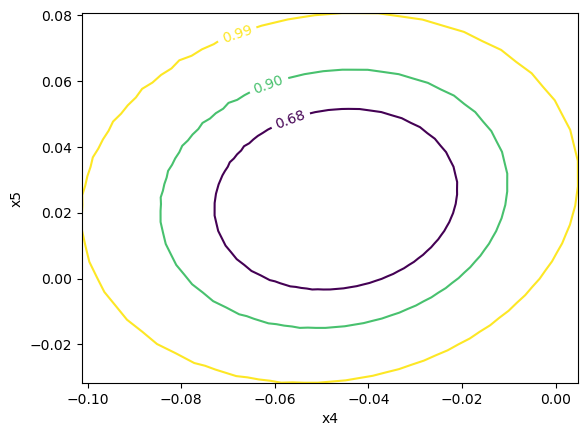

In [12]:
# draw three confidence regions with 68%, 90%, 99% confidence level
m.draw_mncontour("x4", "x5", cl=(0.68, 0.9, 0.99))

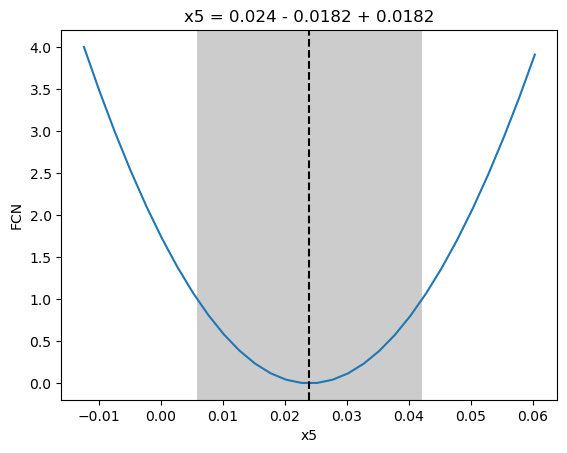

In [13]:
m.draw_mnprofile("x5");

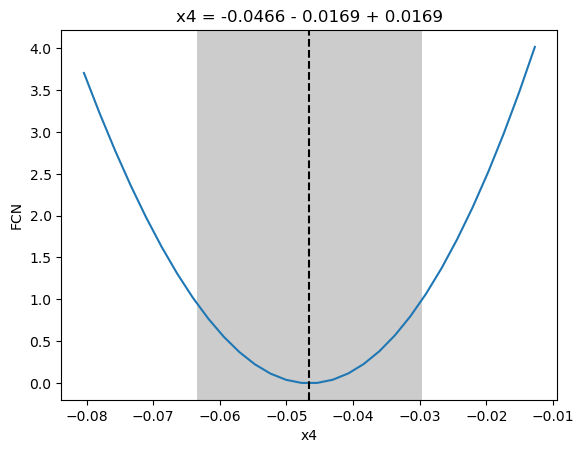

In [14]:
m.draw_mnprofile("x4");

(array([-0.04053606, -0.03910122, -0.03766639, -0.03623155, -0.03479671,
        -0.03336188, -0.03192704, -0.0304922 , -0.02905736, -0.02762253,
        -0.02618769, -0.02475285, -0.02331802, -0.02188318, -0.02044834,
        -0.0190135 , -0.01757867, -0.01614383, -0.01470899, -0.01327416,
        -0.01183932, -0.01040448, -0.00896964, -0.00753481, -0.00609997,
        -0.00466513, -0.0032303 , -0.00179546, -0.00036062,  0.00107422]),
 array([3.91712096e+00, 3.39952421e+00, 2.91791297e+00, 2.47244679e+00,
        2.06328237e+00, 1.69057346e+00, 1.35447076e+00, 1.05512172e+00,
        7.92670507e-01, 5.67257842e-01, 3.79020947e-01, 2.28093445e-01,
        1.14605293e-01, 3.86843509e-02, 4.38497867e-04, 0.00000000e+00,
        3.75096989e-02, 1.13040558e-01, 2.26714065e-01, 3.78633185e-01,
        5.68896958e-01, 7.97600515e-01, 1.06483510e+00, 1.37046477e+00,
        1.71497191e+00, 2.09825595e+00, 2.52039372e+00, 2.98145819e+00,
        3.48151888e+00, 4.02064182e+00]))

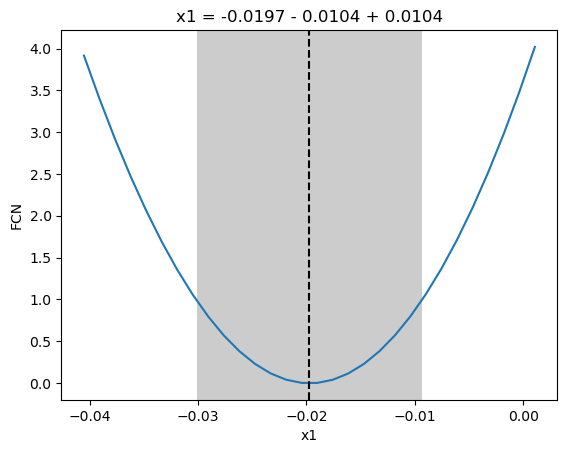

In [15]:
m.draw_mnprofile("x1")

(array([0.03979624, 0.04100496, 0.04221369, 0.04342241, 0.04463113,
        0.04583985, 0.04704858, 0.0482573 , 0.04946602, 0.05067475,
        0.05188347, 0.05309219, 0.05430091, 0.05550964, 0.05671836,
        0.05792708, 0.0591358 , 0.06034453, 0.06155325, 0.06276197,
        0.0639707 , 0.06517942, 0.06638814, 0.06759686, 0.06880559,
        0.07001431, 0.07122303, 0.07243176, 0.07364048, 0.0748492 ]),
 array([3.99407708e+00, 3.46225599e+00, 2.96818210e+00, 2.51190468e+00,
        2.09370249e+00, 1.71312488e+00, 1.37048827e+00, 1.06583496e+00,
        7.99205647e-01, 5.70639463e-01, 3.80199896e-01, 2.27857514e-01,
        1.13690679e-01, 3.77320074e-02, 0.00000000e+00, 5.51403500e-04,
        3.94091648e-02, 1.16580279e-01, 2.32101206e-01, 3.85996277e-01,
        5.78288596e-01, 8.09000094e-01, 1.07815158e+00, 1.38576280e+00,
        1.73185250e+00, 2.11643846e+00, 2.53931656e+00, 3.00089070e+00,
        3.50099460e+00, 4.03963933e+00]))

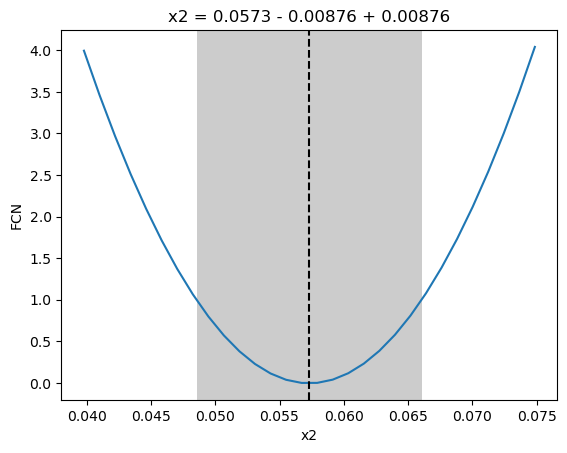

In [16]:
m.draw_mnprofile("x2")